In [278]:
!pip install jovian --upgrade --quiet

In [279]:
import jovian
project_name = 'human-face-generation'

In [280]:
FOLDER_DIR = '../input' 
DATA_DIR = '../input/flickrfaceshq-dataset-ffhq'

In [281]:
import os, shutil


print(os.listdir(DATA_DIR)[:10])

['28487.png', '26541.png', '45541.png', '46366.png', '42871.png', '46207.png', '52109.png', '04161.png', '52917.png', '44501.png']


In [282]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [283]:
image_size = 64
stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)

In [284]:
dataset = ImageFolder( FOLDER_DIR, transform = T.Compose([
                    T.Resize(image_size),
                    T.CenterCrop(image_size),
                    T.ToTensor(),
                    T.Normalize(*stats)]))

In [285]:
from torch.utils.data import DataLoader

In [286]:
batch_size = 128

In [287]:
train_dl = DataLoader(dataset, batch_size, shuffle = True, pin_memory = True, num_workers = 3)

In [288]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [289]:
def denorm(image_tensors):
    
    return image_tensors * stats[0][1] + stats[0][0]

In [290]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images)
        break

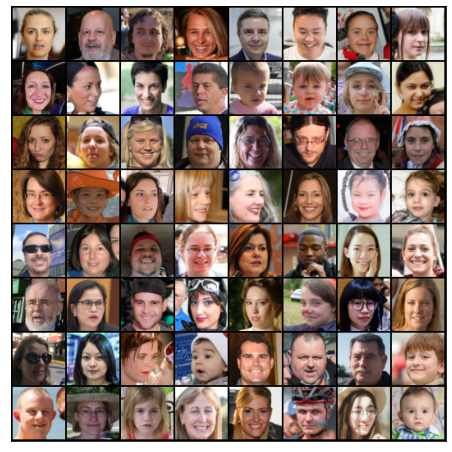

In [291]:
show_batch(train_dl)

In [292]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/human-face-generation


<IPython.core.display.Javascript object>

In [293]:
def get_default_device():
    
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [294]:
def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(each, device) for each in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        
        return len(self.dl)        

In [295]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)

In [296]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/human-face-generation


<IPython.core.display.Javascript object>

In [297]:
import torch.nn as nn

In [298]:
discriminator = nn.Sequential(

    #initial dim : 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    
    #dim : 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    #dim : 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
    
)

In [299]:
discriminator = to_device(discriminator, device)

In [300]:
latent_size = 128

In [301]:
generator = nn.Sequential(

    #initial dim : latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    #dim : 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    #dim : 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    #dim : 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    #dim : 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    
)

torch.Size([128, 3, 64, 64])


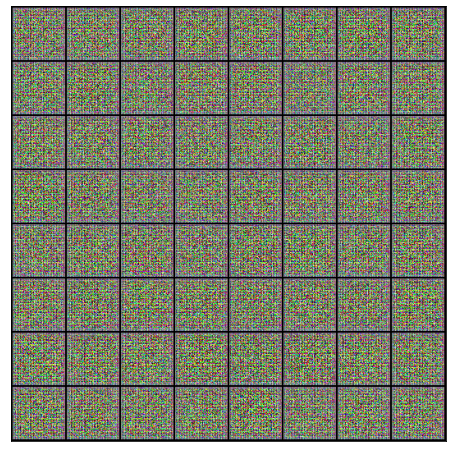

In [302]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)

print(fake_images.shape)
show_images(fake_images)

In [303]:
generator = to_device(generator, device)

In [304]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/human-face-generation


<IPython.core.display.Javascript object>

In [305]:
import torch.nn.functional as F

In [306]:
def train_discriminator(real_images, opt_d):
    
    opt_d.zero_grad()
    
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [307]:
def train_generator(opt_g):
    
    opt_g.zero_grad()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(fake_preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [308]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/human-face-generation


<IPython.core.display.Javascript object>

In [309]:
from torchvision.utils import save_image

In [310]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [311]:
def save_samples(index, latent_tensors, show = True):
    
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [312]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


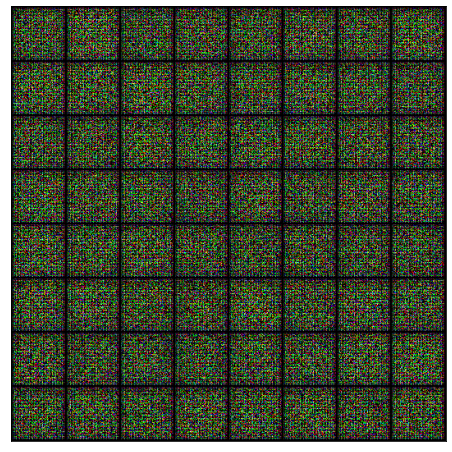

In [313]:
save_samples(0, fixed_latent)

In [314]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/human-face-generation


<IPython.core.display.Javascript object>

In [315]:
from tqdm.notebook import tqdm

In [316]:
def fit(epochs, lr, start_idx = 1):
    
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999)) 
    
    for epoch in range(epochs):
        
        for real_images,_ in tqdm(train_dl):
            
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [317]:
lr = 0.0002
epochs = 25

In [318]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [319]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 8.7598, loss_d: 1.2044, real_score: 0.9609, fake_score: 0.6318
Saving generated-images-0001.png



Epoch [2/25], loss_g: 4.1565, loss_d: 0.7464, real_score: 0.8142, fake_score: 0.3607
Saving generated-images-0002.png



Epoch [3/25], loss_g: 2.0613, loss_d: 0.5795, real_score: 0.6890, fake_score: 0.1182
Saving generated-images-0003.png



Epoch [4/25], loss_g: 2.4788, loss_d: 0.3479, real_score: 0.8057, fake_score: 0.0926
Saving generated-images-0004.png



Epoch [5/25], loss_g: 5.5582, loss_d: 0.7572, real_score: 0.9000, fake_score: 0.4303
Saving generated-images-0005.png



Epoch [6/25], loss_g: 5.6341, loss_d: 0.9317, real_score: 0.9586, fake_score: 0.5268
Saving generated-images-0006.png



Epoch [7/25], loss_g: 4.5275, loss_d: 0.6963, real_score: 0.8809, fake_score: 0.3852
Saving generated-images-0007.png



Epoch [8/25], loss_g: 4.1254, loss_d: 0.2006, real_score: 0.8675, fake_score: 0.0485
Saving generated-images-0008.png



Epoch [9/25], loss_g: 2.3850, loss_d: 0.4308, real_score: 0.7370, fake_score: 0.0828
Saving generated-images-0009.png



Epoch [10/25], loss_g: 1.5531, loss_d: 1.6512, real_score: 0.2855, fake_score: 0.0263
Saving generated-images-0010.png



Epoch [11/25], loss_g: 3.6007, loss_d: 0.3492, real_score: 0.9132, fake_score: 0.2076
Saving generated-images-0011.png



Epoch [12/25], loss_g: 2.5283, loss_d: 0.2725, real_score: 0.9038, fake_score: 0.1343
Saving generated-images-0012.png



Epoch [13/25], loss_g: 2.5887, loss_d: 0.7144, real_score: 0.5418, fake_score: 0.0101
Saving generated-images-0013.png



Epoch [14/25], loss_g: 2.6585, loss_d: 0.3599, real_score: 0.8273, fake_score: 0.1407
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.3827, loss_d: 1.4094, real_score: 0.9450, fake_score: 0.6250
Saving generated-images-0015.png



Epoch [16/25], loss_g: 0.4032, loss_d: 0.9947, real_score: 0.4514, fake_score: 0.0156
Saving generated-images-0016.png



Epoch [17/25], loss_g: 3.0016, loss_d: 0.1706, real_score: 0.8679, fake_score: 0.0185
Saving generated-images-0017.png



Epoch [18/25], loss_g: 1.2802, loss_d: 0.3980, real_score: 0.7271, fake_score: 0.0243
Saving generated-images-0018.png



Epoch [19/25], loss_g: 2.6950, loss_d: 0.2088, real_score: 0.8494, fake_score: 0.0275
Saving generated-images-0019.png



Epoch [20/25], loss_g: 1.4069, loss_d: 0.4704, real_score: 0.7134, fake_score: 0.0768
Saving generated-images-0020.png



Epoch [21/25], loss_g: 2.5877, loss_d: 0.4531, real_score: 0.7925, fake_score: 0.1390
Saving generated-images-0021.png



Epoch [22/25], loss_g: 3.5423, loss_d: 0.2286, real_score: 0.9136, fake_score: 0.1175
Saving generated-images-0022.png



Epoch [23/25], loss_g: 4.6888, loss_d: 1.1628, real_score: 0.9801, fake_score: 0.5290
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.7048, loss_d: 0.4104, real_score: 0.9599, fake_score: 0.2731
Saving generated-images-0024.png



Epoch [25/25], loss_g: 2.3593, loss_d: 0.1930, real_score: 0.8811, fake_score: 0.0525
Saving generated-images-0025.png


In [320]:
losses_g, losses_d, real_scores, fake_scores = history

In [321]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [322]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [323]:
from IPython.display import Image

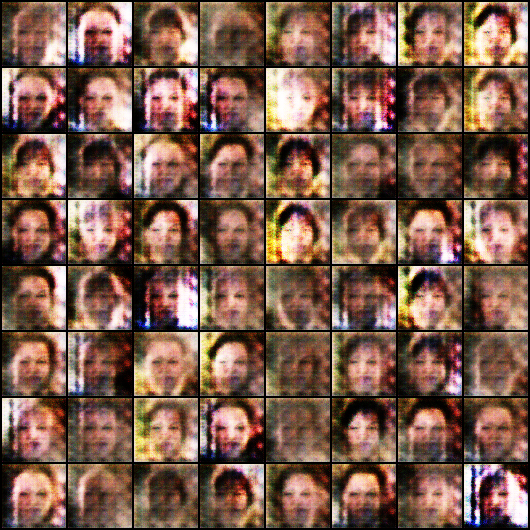

In [324]:
Image('./generated/generated-images-0001.png')

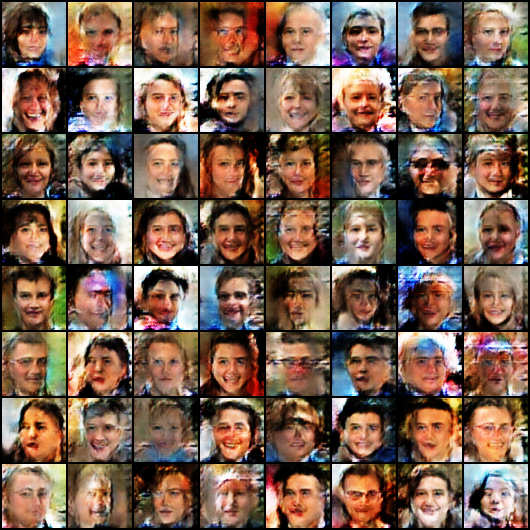

In [325]:
Image('./generated/generated-images-0005.png')

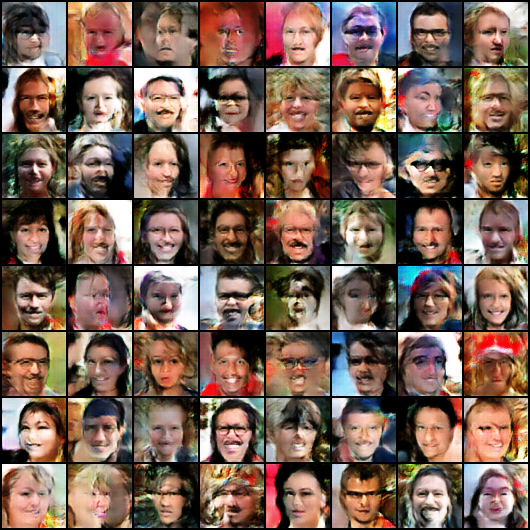

In [326]:
Image('./generated/generated-images-0010.png')

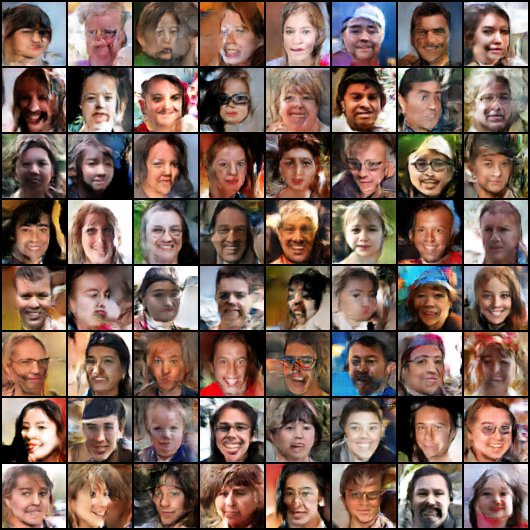

In [327]:
Image('./generated/generated-images-0020.png')

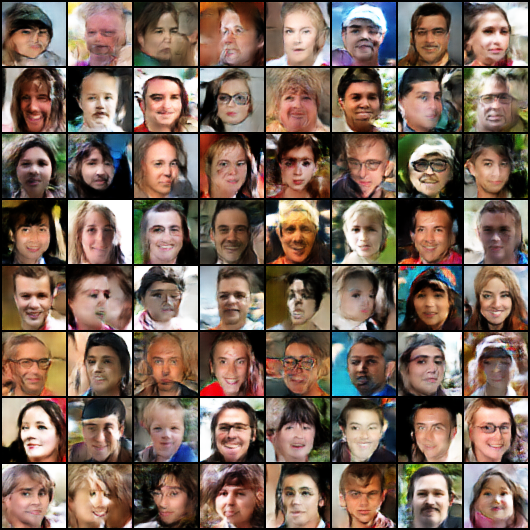

In [328]:
Image('./generated/generated-images-0025.png')

In [333]:
import cv2
import os

vid_fname = 'human_face_generator.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

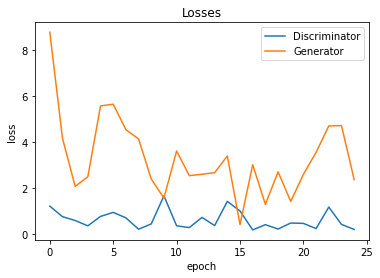

In [334]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

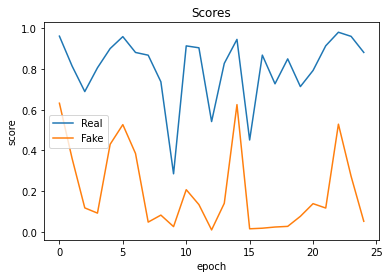

In [335]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [336]:
jovian.commit(project=project_name, 
              outputs=['G.ckpt', 'D.ckpt', 'human_face_generator.avi'], 
              environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/human-face-generation


<IPython.core.display.Javascript object>